In [1]:
import tensorflow as tf
tf.enable_eager_execution()

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [3]:
df = pd.read_csv('dataset3.csv')

In [4]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [5]:
TRAIN_SPLIT = 600
tf.random.set_random_seed(1)

uni_data = df['PM2.5']
uni_data.index = df['No']
uni_data.head()

No
1    29.051190
2    34.834886
3    26.243860
4    19.920647
5    18.552958
Name: PM2.5, dtype: float64

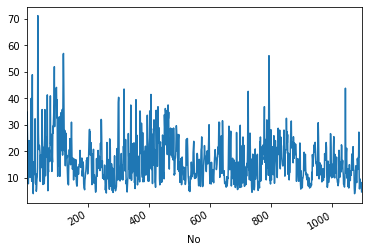

In [6]:
uni_data.plot(subplots=True)
uni_data = uni_data.values

In [7]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [8]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [9]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [10]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [12]:
# EVALUATION_INTERVAL = 200
# EPOCHS = 10
EVALUATION_INTERVAL = 20
EPOCHS = 20

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/20
20/20 [==============================] - 10s 515ms/step - loss: 17.3187 - val_loss: 14.4820
Epoch 2/20
20/20 [==============================] - 2s 82ms/step - loss: 16.7433 - val_loss: 14.1290
Epoch 3/20
20/20 [==============================] - 1s 67ms/step - loss: 16.5623 - val_loss: 13.7989
Epoch 4/20
20/20 [==============================] - 1s 75ms/step - loss: 16.1360 - val_loss: 13.4523
Epoch 5/20
20/20 [==============================] - 1s 73ms/step - loss: 15.7774 - val_loss: 13.1265
Epoch 6/20
20/20 [==============================] - 1s 68ms/step - loss: 15.4398 - val_loss: 12.8011
Epoch 7/20
20/20 [==============================] - 1s 67ms/step - loss: 15.2885 - val_loss: 12.4256
Epoch 8/20
20/20 [==============================] - 1s 69ms/step - loss: 14.8020 - val_loss: 12.0054
Epoch 9/20
20/20 [==============================] - 1s 67ms/step - loss: 14.3495 - val_loss: 11.6039
Epoch 10/20
20/20 [==============================] - 1s 66ms/step - loss: 14.0282 - val_l

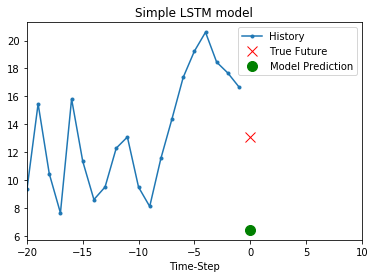

13.06898551
[6.4132185]


In [13]:
for x, y in val_univariate.take(1):
  plot = show_plot([x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()
print(y[0].numpy())
print(simple_lstm_model.predict(x)[0])

In [14]:
features_considered = ['PM2.5','NO2','PM10','SO2','O3','CO','Td dew point','Temperature','WS','WD','StnPres']
features = df[features_considered]
features.index = df['No']
features.head()

,PM2.5,NO2,PM10,SO2,O3,CO,Td dew point,Temperature,WS,WD,StnPres
No,,,,,,,,,,,
1,29.051190,20.022500,58.894048,2.050217,34.137121,0.510857,15.2,19.0,3.9,50,1022.1
2,34.834886,28.810952,69.396429,1.621950,30.830948,0.870893,16.3,18.9,0.6,120,1018.6
3,26.243860,31.635714,45.623810,1.899167,28.177500,0.847381,17.7,19.1,1.1,60,1016.7
4,19.920647,35.578261,38.157402,3.204167,24.224167,1.262833,19.2,20.6,0.4,180,1014.9
5,18.552958,27.550983,37.766527,1.395036,17.291333,0.928394,18.8,20.7,1.2,70,1013.8


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025EBB703F60>,
      dtype=object)

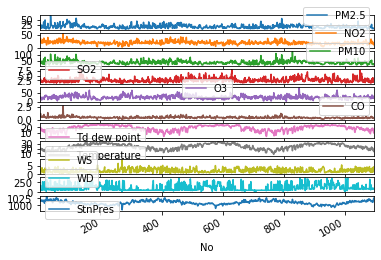

In [15]:
features.plot(subplots=True)

In [16]:
from sklearn.preprocessing import MinMaxScaler
dataset = features.values
values = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled)
dataset = scaled


# scaled=np.reshape(scaled, [-1, 2])
# np.shape(scaled)

[[0.3733692  0.34206986 0.42169327 ... 0.42682925 0.11428571 0.7920151 ]
 [0.45951346 0.512446   0.5086483  ... 0.02439025 0.31428573 0.7184868 ]
 [0.33155584 0.56720775 0.31182173 ... 0.08536585 0.14285715 0.6785717 ]
 ...
 [0.06342506 0.18528767 0.09959919 ... 0.49999997 0.2        0.8655453 ]
 [0.03251391 0.15753973 0.04183735 ... 0.49999997 0.2        0.8235283 ]
 [0.01005368 0.1898224  0.00769621 ... 0.32926825 0.25714284 0.83823586]]


In [17]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [18]:
past_history = 350
future_target = 1
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 0], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 0],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [19]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [20]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/20
20/20 [==============================] - 30s 1s/step - loss: 0.0954 - val_loss: 0.0724
Epoch 2/20
20/20 [==============================] - 26s 1s/step - loss: 0.0888 - val_loss: 0.0734
Epoch 3/20
20/20 [==============================] - 23s 1s/step - loss: 0.0867 - val_loss: 0.0740
Epoch 4/20
20/20 [==============================] - 25s 1s/step - loss: 0.0847 - val_loss: 0.0750
Epoch 5/20
20/20 [==============================] - 23s 1s/step - loss: 0.0830 - val_loss: 0.0749
Epoch 6/20
20/20 [==============================] - 24s 1s/step - loss: 0.0815 - val_loss: 0.0741
Epoch 7/20
20/20 [==============================] - 23s 1s/step - loss: 0.0798 - val_loss: 0.0763
Epoch 8/20
20/20 [==============================] - 23s 1s/step - loss: 0.0780 - val_loss: 0.0737
Epoch 9/20
20/20 [==============================] - 23s 1s/step - loss: 0.0771 - val_loss: 0.0746
Epoch 10/20
20/20 [==============================] - 24s 1s/step - loss: 0.0755 - val_loss: 0.0754
Epoch 11/20
20/20 [

In [21]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

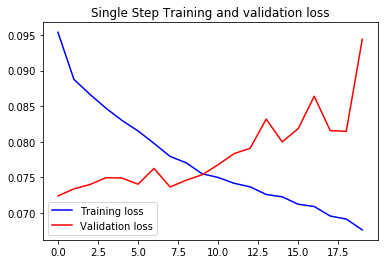

In [22]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

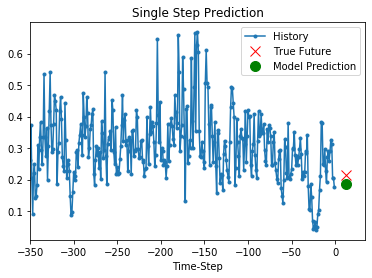

In [23]:
for x, y in val_data_single.take(1):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [24]:
future_target = 2
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 0], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [25]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [26]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

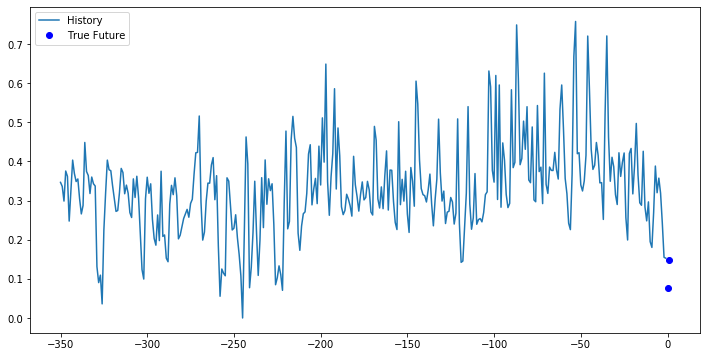

In [27]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [28]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(2))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [29]:
EVALUATION_INTERVAL = 50
EPOCHS = 5

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/5
50/50 [==============================] - 109s 2s/step - loss: 0.0957 - val_loss: 0.0734
Epoch 2/5
50/50 [==============================] - 102s 2s/step - loss: 0.0873 - val_loss: 0.0749
Epoch 3/5
50/50 [==============================] - 111s 2s/step - loss: 0.0838 - val_loss: 0.0751
Epoch 4/5
50/50 [==============================] - 124s 2s/step - loss: 0.0805 - val_loss: 0.0745
Epoch 5/5
50/50 [==============================] - 133s 3s/step - loss: 0.0777 - val_loss: 0.0769


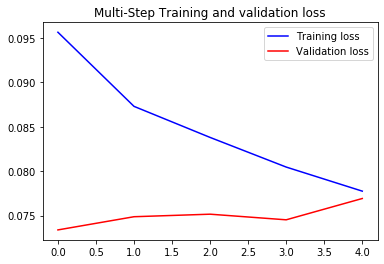

In [30]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

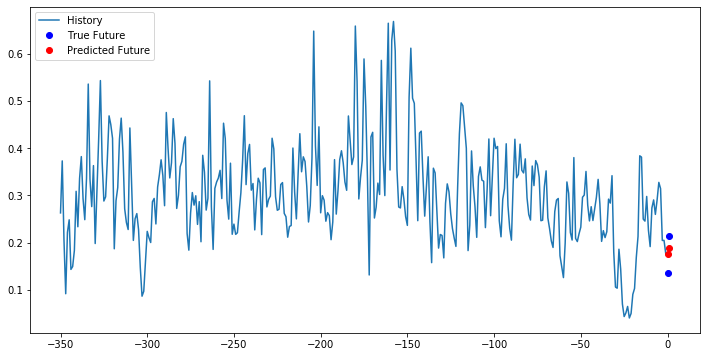

[15.752    16.693945]
tf.Tensor([13.093116 18.349243], shape=(2,), dtype=float32)


In [31]:
for x, y in val_data_multi.take(1):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

# a=tf.reshape(y[0], [-1, 2])
# b=tf.reshape(x[0],[-1,2])
# c=tf.reshape(multi_step_model.predict(x)[0],[-1,2])


# new_a=scaler.inverse_transform(a)
a=multi_step_model.predict(x)[0]-scaler.min_[0]/scaler.scale_[0]
b=(y[0]-scaler.min_[0])/scaler.scale_[0]
print((multi_step_model.predict(x)[0]-scaler.min_[0])/scaler.scale_[0])
print((y[0]-scaler.min_[0])/scaler.scale_[0])


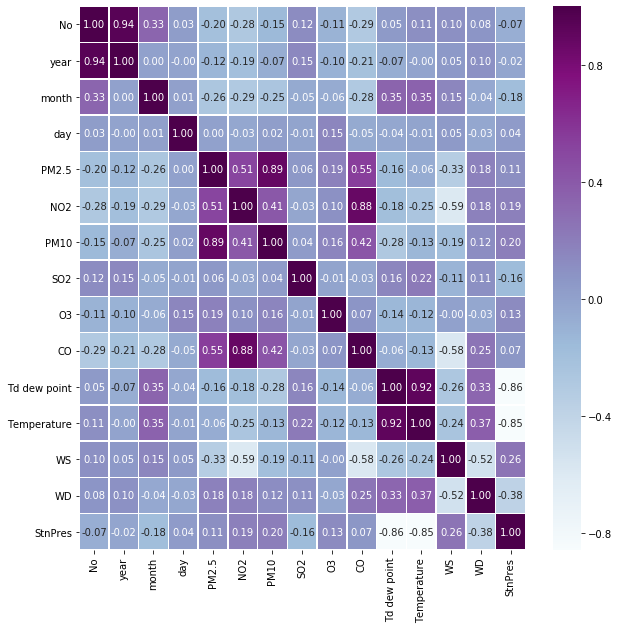

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import numpy as np
import pandas as pd
fig,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), ax=ax, annot=True, linewidths=0.5, fmt= '.2f',cmap="BuPu")
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error
rmse = sqrt(mean_squared_error(a, b))
mse =mean_squared_error(a, b)
MAE =mean_absolute_error(a, b)
print('RMSE: %.2f' % rmse)
print('MSE: %.2f' % mse)
print('MAE: %.2f' % MAE)

RMSE: 11.85
MSE: 140.40
MAE: 11.56


In [34]:
multi_step_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 350, 32)           5632      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
Total params: 8,802
Trainable params: 8,802
Non-trainable params: 0
_________________________________________________________________
